In [1]:
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
from itertools import islice
import numpy as np
from skimage.external import tifffile
from skimage.external.tifffile import imread
import matplotlib.pyplot as plt
import ipywidgets as widgets
import random
from scipy.ndimage.morphology import binary_erosion as br
from skimage import morphology as skmor
from scipy import ndimage
from PIL import Image, ImageDraw
import numpy.ma as ma
from skimage.measure import label, regionprops

from sklearn.cluster import KMeans


In [2]:
import seaborn as sns

# Pixel Distribution for HP1 signals

This script is to see the 'pixel distribution' of the images randomly selected from two experiments, which differ in which staining they have used. 10 samples will be chosen from each HP1 and HP1Beta groups, and each images and its HP1 (or HP1Beta) signals and DAPI signals will be assessed to find a difference between the HP1 stainings. 
<br>

# Contents
* [Data Loading](#data)
* [Sampling](#samples)
* [Data Analysis](#EDA)
    1. [first image](#1st)
    2. [second image](#2nd)
    3. [third image](#3rd)
* [Compare mean and max values](#meanMax)

## Pixel Distribution of HP1 (HP1B) and DAPI signal <a name="data"></a>
- Select random 10 cells from the chosen dataset
- calculate HP1 (HP1B) signal and DAPI signal for each pixel of the image
- plot HP1 signal vs DAPI signal for each cell 
- look for any pattern noticed - ex) normal linear relationship, grouping in the plots, etc

In [3]:
bigDir=r'Z:\CookLab\Liu\20190816_organizedData_MCM_loading'

In [4]:
newfile=f'{bigDir}\\new dataset\signals_new_v5.csv'

In [5]:
newdata=pd.read_csv(newfile)

In [6]:
newdata=newdata.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

In [7]:
newdata.head()

file original cell name                       movie  \
0  20191203_cell-00.czi     20191125-01-17  191125pcnat_dhbr_cdc6vxy01   
1  20191203_cell-01.czi     20191125-01-20  191125pcnat_dhbr_cdc6vxy01   
2  20191203_cell-02.czi     20191125-01-23  191125pcnat_dhbr_cdc6vxy01   
3  20191203_cell-03.czi     20191125-01-25  191125pcnat_dhbr_cdc6vxy01   
4  20191203_cell-04.czi     20191125-01-32  191125pcnat_dhbr_cdc6vxy01   

   last frame movie position x  last frame movie position y ab1 (MCM)  ab1 ch  \
0                      678.301                      200.931      MCM3       1   
1                     1552.152                      240.479      MCM3       1   
2                     1131.436                      318.530      MCM3       1   
3                     1650.585                      324.968      MCM3       1   
4                     1466.687                      426.815      MCM3       1   

  ab2 (heterochromatin)  ab2 ch  DAPI ch  ...  mol_age_mod nuc_hp1b_total  \
0               HP1beta       2        3  ...        0.444   1.415176e+09   
1               HP1beta       2        3  ...        1.373   2.175016e+09   
2               HP1beta       2        3  ...        1.371   1.933001e+09   
3               HP1beta       2        3  ...        0.208   1.062142e+09   
4               HP1beta       2        3  ...        0.345   1.717888e+09   

   inner_hp1b_total  outer_hp1b_total nuc_hp1b_het  inner_hp1b_het  \
0       425500564.0      9.896759e+08  550518042.0     321679433.0   
1       804184935.0      1.370831e+09  896267478.0     567124747.0   
2       666820604.0      1.266180e+09  732487366.0     444813519.0   
3       233589820.0      8.285525e+08  403943621.0     187675893.0   
4       546330833.0      1.171557e+09  697150763.0     424718652.0   

  outer_hp1b_het   nuc_hp1b_eu inner_hp1b_eu  outer_hp1b_eu  
0    228838609.0  8.646584e+08   103821131.0   7.608373e+08  
1    329142731.0  1.278748e+09   237060188.0   1.041688e+09  
2    287673847.0  1.200514e+09   222007085.0   9.785064e+08  
3    216267728.0  6.581987e+08    45913927.0   6.122848e+08  
4    272432111.0  1.020738e+09   121612181.0   8.991254e+08  

[5 rows x 59 columns]

In [8]:
file=f'{bigDir}\\20200217_geminin\\200217_cellinfo_v7.csv'

In [9]:
geminin=pd.read_csv(file)

In [10]:
geminin=geminin.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

In [11]:
geminin.head()

file     original cell name                         movie  \
0  20200217_cell_00.ciz  2020024-19-21-63X.czi  20200217pinducer gemininxy19   
1  20200217_cell_01.ciz  2020024-19-27-63X.czi  20200217pinducer gemininxy19   
2  20200217_cell_02.ciz  2020024-19-39-63X.czi  20200217pinducer gemininxy19   
3  20200217_cell_03.ciz  2020024-19-49-63X.czi  20200217pinducer gemininxy19   
4  20200217_cell_04.ciz  2020024-19-51-63X.czi  20200217pinducer gemininxy19   

          x        y ab1 (MCM)  ab1 ch ab2 (heterochromatin)  ab2 ch  DAPI ch  \
0  1312.741  235.893      MCM3       1                   HP1       2        3   
1  1323.444  397.761      MCM3       1                   HP1       2        3   
2  1772.297  584.995      MCM3       1                   HP1       2        3   
3   163.044  727.256      MCM3       1                   HP1       2        3   
4  1791.955  755.367      MCM3       1                   HP1       2        3   

   ...  outer_DAPI_total  nuc_DAPI_het inner_DAPI_het  outer_DAPI_het  \
0  ...      1.425797e+09  7.791948e+08   4.701984e+08     308996412.0   
1  ...      1.407304e+09  7.501514e+08   4.772260e+08     272925417.0   
2  ...      2.488888e+09  1.402612e+09   1.055936e+09     346675531.0   
3  ...      1.395355e+09  8.721556e+08   6.594996e+08     212655978.0   
4  ...      1.422570e+09  7.409389e+08   4.345226e+08     306416352.0   

    nuc_DAPI_eu inner_DAPI_eu outer_DAPI_eu        day physical_age  \
0  1.214105e+09    97303963.0  1.116801e+09  d20200217     8.833333   
1  1.302409e+09   168031096.0  1.134378e+09  d20200217     5.666667   
2  2.494576e+09   352363680.0  2.142212e+09  d20200217          NaN   
3  1.360779e+09   178079736.0  1.182699e+09  d20200217     7.833333   
4  1.222306e+09   106151998.0  1.116154e+09  d20200217     5.666667   

   mol_age_mod  
0        0.948  
1        0.465  
2        2.001  
3        1.063  
4        0.579  

[5 rows x 49 columns]

## Sampling  <a name="samples"></a>

sample = 10 samples from newdata; this data used ***HP1Beta***<br>
sample_geminin = 10 samples from geminin dataset; this data used ***HP1***

In [12]:
sample=newdata.loc[(newdata.decon==False),:]

In [13]:
sample=sample.loc[(['G1' in x for x in sample.category]), :].sample(n=10, random_state=107)

In [14]:
sample

file original cell name                       movie  \
102  20191203_cell-130.czi    20191125-08-101  191125pcnat_dhbr_cdc6vxy08   
3     20191203_cell-03.czi     20191125-01-25  191125pcnat_dhbr_cdc6vxy01   
108  20191203_cell-137.czi     20191125-11-82  191125pcnat_dhbr_cdc6vxy11   
58    20191203_cell-78.czi     20191125-05-44  191125pcnat_dhbr_cdc6vxy05   
49    20191203_cell-64.czi    20191125-10-142  191125pcnat_dhbr_cdc6vxy10   
67    20191203_cell-87.czi     20191125-05-88  191125pcnat_dhbr_cdc6vxy05   
81   20191203_cell-103.czi     20191125-07-55  191125pcnat_dhbr_cdc6vxy07   
60    20191203_cell-80.czi     20191125-05-56  191125pcnat_dhbr_cdc6vxy05   
95   20191203_cell-123.czi    20191125-07-125  191125pcnat_dhbr_cdc6vxy07   
5     20191203_cell-05.czi     20191125-01-36  191125pcnat_dhbr_cdc6vxy01   

     last frame movie position x  last frame movie position y ab1 (MCM)  \
102                     1237.094                     1258.126      MCM3   
3                       1650.585                      324.968      MCM3   
108                      916.914                      921.865      MCM3   
58                       947.721                      652.410      MCM3   
49                       520.447                     1594.921      MCM3   
67                       301.901                     1450.886      MCM3   
81                       598.905                      812.930      MCM3   
60                       467.635                      889.574      MCM3   
95                      1258.357                     1764.788      MCM3   
5                       1705.099                      468.246      MCM3   

     ab1 ch ab2 (heterochromatin)  ab2 ch  DAPI ch  ...  mol_age_mod  \
102       1               HP1beta       2        3  ...        0.721   
3         1               HP1beta       2        3  ...        0.208   
108       1               HP1beta       2        3  ...        0.701   
58        1               HP1beta       2        3  ...        0.422   
49        1               HP1beta       2        3  ...        1.009   
67        1               HP1beta       2        3  ...        0.208   
81        1               HP1beta       2        3  ...        0.462   
60        1               HP1beta       2        3  ...        0.674   
95        1               HP1beta       2        3  ...        0.649   
5         1               HP1beta       2        3  ...        0.632   

    nuc_hp1b_total  inner_hp1b_total  outer_hp1b_total nuc_hp1b_het  \
102   1.285848e+09       390107622.0      8.957405e+08  487715875.0   
3     1.062142e+09       233589820.0      8.285525e+08  403943621.0   
108   1.340251e+09       442330664.0      8.979200e+08  509021593.0   
58    1.216596e+09       363577325.0      8.530182e+08  456375018.0   
49    1.448302e+09       408907699.0      1.039394e+09  561312449.0   
67    1.173185e+09       255938367.0      9.172463e+08  438885958.0   
81    1.039684e+09       208705380.0      8.309790e+08  384549104.0   
60    1.373778e+09       453944387.0      9.198338e+08  519606383.0   
95    1.204104e+09       355183847.0      8.489197e+08  434319799.0   
5     1.615431e+09       530009467.0      1.085421e+09  699466569.0   

     inner_hp1b_het outer_hp1b_het  nuc_hp1b_eu inner_hp1b_eu  outer_hp1b_eu  
102     290984487.0    196731388.0  798132293.0    99123135.0    699009158.0  
3       187675893.0    216267728.0  658198734.0    45913927.0    612284807.0  
108     325983023.0    183038570.0  831229094.0   116347641.0    714881453.0  
58      263518999.0    192856019.0  760220527.0   100058326.0    660162201.0  
49      288467325.0    272845124.0  886989714.0   120440374.0    766549340.0  
67      196474325.0    242411633.0  734298719.0    59464042.0    674834677.0  
81      167188893.0    217360211.0  655135258.0    41516487.0    613618771.0  
60      326294309.0    193312074.0  854171789.0   127650078.0    726521711.0  
95      257178787.0    177141012.0  769783719.0    98005060.0 

In [15]:
sample_geminin=geminin.loc[(geminin.group=='CTL'),:]

sample_geminin=sample_geminin.loc[(['G1' in x for x in sample_geminin.category]), :].sample(n=10, random_state=107)

sample_geminin

file      original cell name  \
55  20200217_cell_56.ciz   2020024-21-69-63X.czi   
52  20200217_cell_53.ciz   2020024-21-56-63X.czi   
41  20200217_cell_41.ciz  2020024-20-129-63X.czi   
33  20200217_cell_33.ciz   2020024-20-72-63X.czi   
0   20200217_cell_00.ciz   2020024-19-21-63X.czi   
39  20200217_cell_39.ciz  2020024-20-111-63X.czi   
59  20200217_cell_60.ciz   2020024-21-91-63X.czi   
58  20200217_cell_59.ciz   2020024-21-84-63X.czi   
9   20200217_cell_09.ciz   2020024-19-79-63X.czi   
12  20200217_cell_12.ciz   2020024-19-93-63X.czi   

                           movie         x         y ab1 (MCM)  ab1 ch  \
55  20200217pinducer gemininxy21  1679.774   853.901      MCM3       1   
52  20200217pinducer gemininxy21   491.477   686.327      MCM3       1   
41  20200217pinducer gemininxy20   956.116  1670.198      MCM3       1   
33  20200217pinducer gemininxy20   693.390   929.068      MCM3       1   
0   20200217pinducer gemininxy19  1312.741   235.893      MCM3       1   
39  20200217pinducer gemininxy20  1306.021  1454.848      MCM3       1   
59  20200217pinducer gemininxy21  1292.148  1095.184      MCM3       1   
58  20200217pinducer gemininxy21  1388.189  1001.713      MCM3       1   
9   20200217pinducer gemininxy19   398.674  1037.764      MCM3       1   
12  20200217pinducer gemininxy19  1841.328  1182.675      MCM3       1   

   ab2 (heterochromatin)  ab2 ch  DAPI ch  ...  outer_DAPI_total nuc_DAPI_het  \
55                   HP1       2        3  ...      1.831348e+09  735528431.0   
52                   HP1       2        3  ...      1.325073e+09  989964835.0   
41                   HP1       2        3  ...      1.430629e+09  825203997.0   
33                   HP1       2        3  ...      1.555030e+09  993091013.0   
0                    HP1       2        3  ...      1.425797e+09  779194775.0   
39                   HP1       2        3  ...      1.181791e+09  760838823.0   
59                   HP1       2        3  ...      1.531307e+09  911067747.0   
58                   HP1       2        3  ...      1.460786e+09  894902823.0   
9                    HP1       2        3  ...      1.525443e+09  890740746.0   
12                   HP1       2        3  ...      1.530362e+09  839243088.0   

   inner_DAPI_het  outer_DAPI_het   nuc_DAPI_eu inner_DAPI_eu outer_DAPI_eu  \
55    342193413.0     393335018.0  1.575331e+09   137317117.0  1.438013e+09   
52    799149458.0     190815377.0  1.367327e+09   233069560.0  1.134257e+09   
41    592632646.0     232571351.0  1.346245e+09   148187340.0  1.198057e+09   
33    752317813.0     240773200.0  1.507446e+09   193189960.0  1.314256e+09   
0     470198363.0     308996412.0  1.214105e+09    97303963.0  1.116801e+09   
39    603861106.0     156977717.0  1.152483e+09   127669744.0  1.024813e+09   
59    625595380.0     285472367.0  1.462186e+09   216351806.0  1.245835e+09   
58    644872562.0     250030261.0  1.406651e+09   195894622.0  1.210756e+09   
9     604191565.0     286549181.0  1.412280e+09   173386032.0  1.238894e+09   
12    548132923.0     291110165.0  1.350745e+09   111493747.0  1.239252e+09   

          day physical_age  mol_age_mod  
55  d20200217     7.166667        0.913  
52  d20200217     2.833333        0.312  
41  d20200217     7.333333        0.980  
33  d20200217     9.666667        1.098  
0   d20200217     8.833333        0.948  
39  d20200217     3.166667        0.282  
59  d20200217     5.000000        0.222  
58  d20200217     7.333333        0.844  
9   d20200217     6.833333        0.726  
12  d20200217     2.000000        0.429  

[10 rows x 49 columns]

# Data Analysis <a name="EDA"></a>

## first image <a name="1st"></a>
* [Density plots](#1Density)
* [Sample plots](#1Sample)
* [Comparison](#1Comparison)

In [111]:
i=0

In [112]:
mycell=sample.iloc[i]
%matplotlib notebook
cell=imread(mycell.path)

nucPath=(mycell.path.replace('data_tiff','segmentation_nucleus_Otsu'))
nucPath=nucPath.replace('.tif','_nucleus.tif')
nuc=imread(nucPath)

print(mycell.file)
print('shape of the cell image: ', cell.shape)
print('shape of nucleus mask: ', nuc.shape)

nuc=nuc.astype(bool)
# selecting every slide of the selected channel, which is hp1beta channel.
hp1b=cell[:,1,:,:] 
## masking the image
hp1b[~nuc]=0
hp1b=hp1b.astype(np.ndarray)

# DAPI channel
dapiB=cell[:,2,:,:]
dapiB[~nuc]=0


## HP1, geminin dataset
i=0
mycellGeminin=sample_geminin.iloc[i]
%matplotlib notebook
cell=imread(mycellGeminin.path)

nucPath=(mycellGeminin.path.replace('data_tiff','segmentation_nucleus_Otsu'))
nucPath=nucPath.replace('.tif','_nucleus.tif')
nuc=imread(nucPath)

print(mycellGeminin.file)
print('shape of the cell image: ', cell.shape)
print('shape of nucleus mask: ', nuc.shape)

nuc=nuc.astype(bool)
# selecting every slide of the selected channel, which is hp1beta channel.
hp1=cell[:,1,:,:] 
## masking the image
hp1[~nuc]=0
hp1=hp1.astype(np.ndarray)

# DAPI channel
dapi=cell[:,2,:,:]
dapi[~nuc]=0


20191203_cell-130.czi
shape of the cell image:  (29, 3, 380, 380)
shape of nucleus mask:  (29, 380, 380)
20200217_cell_56.ciz
shape of the cell image:  (22, 3, 380, 380)
shape of nucleus mask:  (22, 380, 380)


#### making hp1beta and dapi signals as 1d (reducing the factor of slices or any axis limitations)

In [113]:
hp1b.max()

65535

In [114]:
dapiB.max()

41919

By using `ravel()`, the signals' multidimensional array will be made into 1-dimensional array. This will enable us to just plot the pixels without any grouping of slices or axes.

In [115]:
hp1b_test=hp1b.ravel()
hp1b_test.shape

(4187600,)

In [116]:
dapiB_test=dapiB.ravel()
dapiB_test.shape

(4187600,)

#### making hp1 and dapi signals as 1d (reducing the factor of slices or any axis limitations)
By using `ravel()`, the signals' multidimensional array will be made into 1-dimensional array. This will enable us to just plot the pixels without any grouping of slices or axes.

In [117]:
hp1.max()

47432

In [118]:
dapi.max()

31365

In [119]:
hp1_test=hp1.ravel()
hp1_test.shape

(3176800,)

In [120]:
dapi_test=dapi.ravel()
dapi_test.shape

(3176800,)

## remove some data points

- remove pixel values of saturated pixels and 0 pixels, which are most likly the background pixels

### HP1Beta

In [126]:
hp1b_test[hp1b_test==0].shape

(3952366,)

In [127]:
hp1b_test_non_zero=hp1b_test[~(hp1b_test==0)]

In [128]:
hp1b_test_non_zero.shape

(235234,)

In [129]:
dapiB_test[dapiB_test==0].shape

(3952366,)

In [130]:
dapiB_test_non_zero=dapiB_test[~(dapiB_test==0)]

In [131]:
dapiB_test_non_zero.shape

(235234,)

### HP1

In [132]:
hp1_test_non_zero=hp1_test[~(hp1_test==0)]

In [133]:
hp1_test_non_zero.shape

(208612,)

In [134]:
dapi_test_non_zero=dapi_test[~(dapi_test==0)]

In [135]:
dapi_test_non_zero.shape

(208612,)

## density plot <a name="1Density"></a>

### HP1Beta

In [136]:
hp1b_test_final=hp1b_test_non_zero[hp1b_test_non_zero!=hp1b_test_non_zero.max()]

In [138]:
dapiB_test_final=dapiB_test_non_zero[hp1b_test_non_zero!=hp1b_test_non_zero.max()]

In [139]:
print(hp1b_test_final.shape)
print(dapiB_test_final.shape)

(235219,)
(235219,)


I have plotted a scatter plot of HP1Beta vs DAPI signals for the image. 

<IPython.core.display.Javascript object>


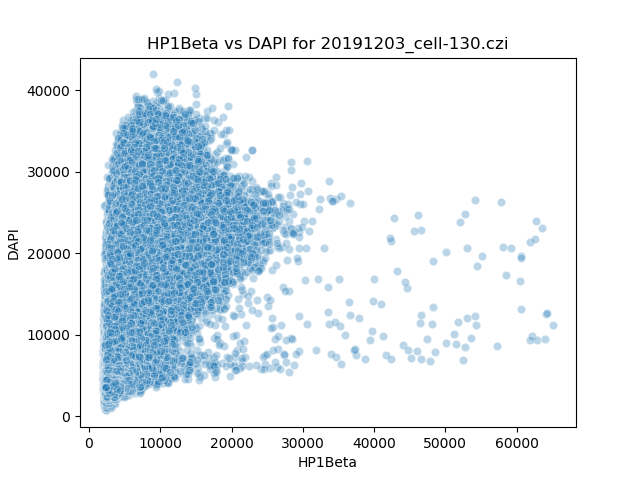

Text(0.5, 1.0, 'HP1Beta vs DAPI for 20191203_cell-130.czi')

In [140]:
%matplotlib notebook
sns.scatterplot(x=hp1b_test_final,y=dapiB_test_final,alpha=0.3)
plt.ticklabel_format(axis='both',style='sci')
plt.xlabel('HP1Beta')
plt.ylabel('DAPI')
plt.title(f'HP1Beta vs DAPI for {mycell.file}')

This is the density plot of the same scatterplot. The histograms on the both axes show the distribution of each variable. 

<IPython.core.display.Javascript object>


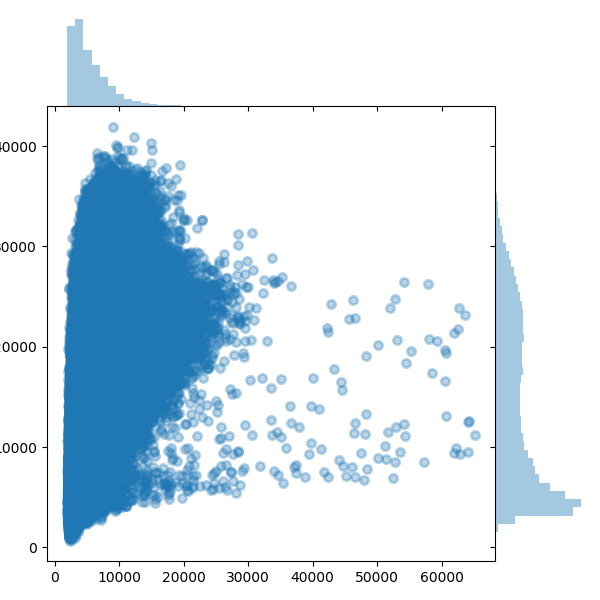

In [141]:
%matplotlib notebook
sns.jointplot(x=hp1b_test_final,y=dapiB_test_final,kind='scatter', linewidth=2,alpha=0.3,space=0)

### HP1

<IPython.core.display.Javascript object>


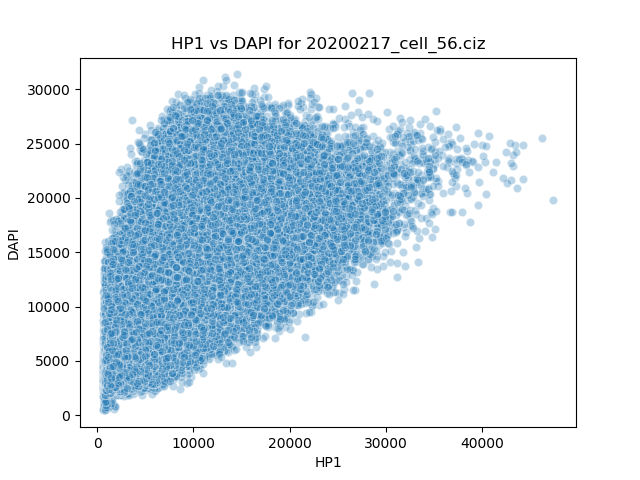

Text(0.5, 1.0, 'HP1 vs DAPI for 20200217_cell_56.ciz')

In [70]:
%matplotlib notebook
sns.scatterplot(x=hp1_test_non_zero,y=dapi_test_non_zero,alpha=0.3)
plt.ticklabel_format(axis='both',style='sci')
plt.xlabel('HP1')
plt.ylabel('DAPI')
plt.title(f'HP1 vs DAPI for {mycellGeminin.file}')

<IPython.core.display.Javascript object>


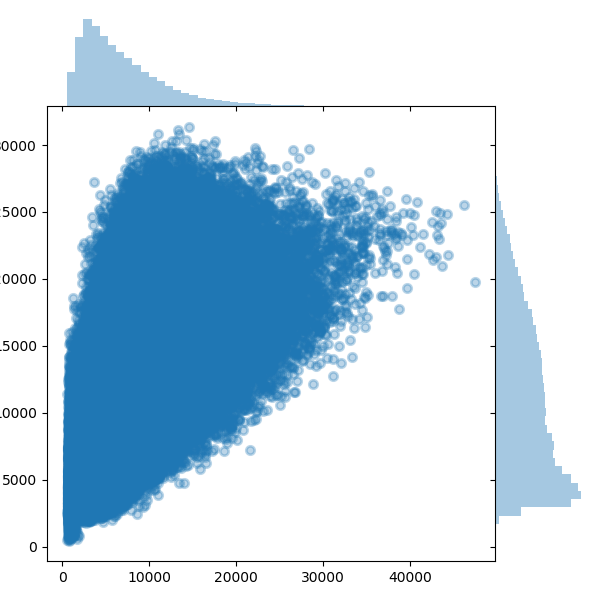

In [71]:
%matplotlib notebook
sns.jointplot(x=hp1_test_non_zero,y=dapi_test_non_zero,kind='scatter', linewidth=2,alpha=0.3,space=0)

## Sample plots <a name="1Sample"></a>

### samples from non-zero array

In [145]:
idx = np.random.choice(np.arange(len(hp1b_test_final)), 1000, replace=False)
hp1b_test_sample = hp1b_test_final[idx]
dapiB_test_sample = dapiB_test_final[idx]

In [146]:
hp1b_test_sample.shape

(1000,)

<IPython.core.display.Javascript object>


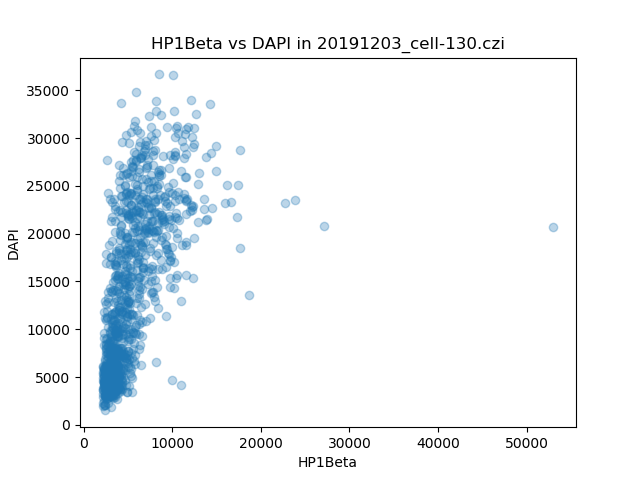

Text(0.5, 1.0, 'HP1Beta vs DAPI in 20191203_cell-130.czi')

In [147]:
%matplotlib notebook
plt.scatter(x=hp1b_test_sample, y= dapiB_test_sample, alpha=0.3)
plt.xlabel('HP1Beta')
plt.ylabel('DAPI')
plt.title(f'HP1Beta vs DAPI in {mycell.file}')

### samples from non-zero array

In [148]:
idx = np.random.choice(np.arange(len(hp1_test_non_zero)), 1000, replace=False)
hp1_test_sample = hp1_test_non_zero[idx]
dapi_test_sample = dapi_test_non_zero[idx]

In [149]:
hp1_test_sample.shape

(1000,)

<IPython.core.display.Javascript object>


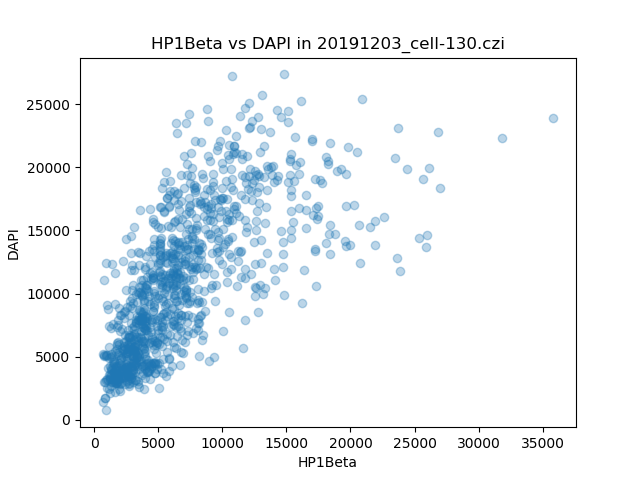

Text(0.5, 1.0, 'HP1Beta vs DAPI in 20191203_cell-130.czi')

In [150]:
%matplotlib notebook
plt.scatter(x=hp1_test_sample, y= dapi_test_sample, alpha=0.3)
plt.xlabel('HP1Beta')
plt.ylabel('DAPI')
plt.title(f'HP1Beta vs DAPI in {mycell.file}')

## compare HP1 and HP1B <a name="1Comparison"></a>

<IPython.core.display.Javascript object>


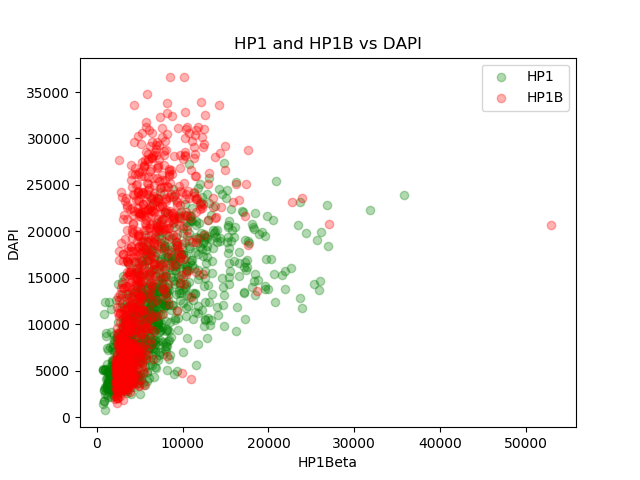

Text(0.5, 1.0, 'HP1 and HP1B vs DAPI')

In [151]:
%matplotlib notebook
plt.scatter(x=hp1_test_sample, y= dapi_test_sample, alpha=0.3, color='green', label='HP1')
plt.scatter(x=hp1b_test_sample, y= dapiB_test_sample, alpha=0.3, color='red', label='HP1B')

plt.legend()
plt.xlabel('HP1Beta')
plt.ylabel('DAPI')
plt.title(f'HP1 and HP1B vs DAPI')

# second image <a name="2nd"></a>
* [Density plots](#2Density)
* [Sample plots](#2Sample)
* [Comparison](#2Comparison)

In [81]:
i+=1

In [82]:
mycell=sample.iloc[i]
%matplotlib notebook
cell=imread(mycell.path)

nucPath=(mycell.path.replace('data_tiff','segmentation_nucleus_Otsu'))
nucPath=nucPath.replace('.tif','_nucleus.tif')
nuc=imread(nucPath)

print("HP1B")
print(mycell.file)
print('shape of the cell image: ', cell.shape)
print('shape of nucleus mask: ', nuc.shape)

nuc=nuc.astype(bool)
# selecting every slide of the selected channel, which is hp1beta channel.
hp1b=cell[:,1,:,:] 
## masking the image
hp1b[~nuc]=0
hp1b=hp1b.astype(np.ndarray)

# DAPI channel
dapiB=cell[:,2,:,:]
dapiB[~nuc]=0


mycellGeminin=sample_geminin.iloc[i]
%matplotlib notebook
cell=imread(mycellGeminin.path)

nucPath=(mycellGeminin.path.replace('data_tiff','segmentation_nucleus_Otsu'))
nucPath=nucPath.replace('.tif','_nucleus.tif')
nuc=imread(nucPath)

print("HP1")
print(mycellGeminin.file)
print('shape of the cell image: ', cell.shape)
print('shape of nucleus mask: ', nuc.shape)

nuc=nuc.astype(bool)
# selecting every slide of the selected channel, which is hp1beta channel.
hp1=cell[:,1,:,:] 
## masking the image
hp1[~nuc]=0
hp1=hp1.astype(np.ndarray)

# DAPI channel
dapi=cell[:,2,:,:]
dapi[~nuc]=0


HP1B
20191203_cell-03.czi
shape of the cell image:  (37, 3, 380, 380)
shape of nucleus mask:  (37, 380, 380)
HP1
20200217_cell_53.ciz
shape of the cell image:  (24, 3, 380, 380)
shape of nucleus mask:  (24, 380, 380)


In [83]:
hp1b_test=hp1b.ravel()
dapiB_test=dapiB.ravel()

In [84]:
hp1_test=hp1.ravel()
dapi_test=dapi.ravel()

#### remove 0 

In [85]:
hp1_test_non_zero=hp1_test[~(hp1_test==0)]
hp1_test_non_zero.shape

(328497,)

In [86]:
dapi_test_non_zero=dapi_test[~(dapi_test==0)]
dapi_test_non_zero.shape

(328497,)

In [92]:
hp1b_test_non_zero=hp1b_test[~(hp1b_test==0)]
hp1b_test_non_zero.shape

(223869,)

In [93]:
dapiB_test_non_zero=dapiB_test[~(dapiB_test==0)]
dapiB_test_non_zero.shape

(223869,)

## Density plot <a name="2Density"></a>

### HP1Beta

In [96]:
hp1b_test_final=hp1b_test_non_zero[hp1b_test_non_zero!=hp1b_test_non_zero.max()]

In [97]:
dapiB_test_final=dapiB_test_non_zero[hp1b_test_non_zero!=hp1b_test_non_zero.max()]

In [98]:
print(hp1b_test_final.shape)
print(dapiB_test_final.shape)

(223868,)
(223868,)


<IPython.core.display.Javascript object>


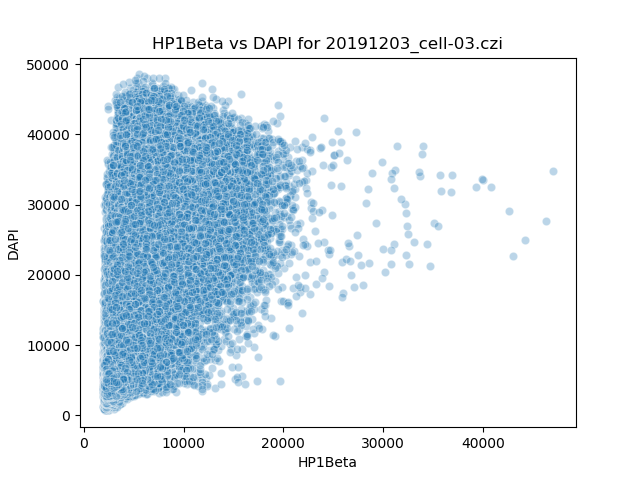

Text(0.5, 1.0, 'HP1Beta vs DAPI for 20191203_cell-03.czi')

In [99]:
%matplotlib notebook
sns.scatterplot(x=hp1b_test_final,y=dapiB_test_final,alpha=0.3)
plt.ticklabel_format(axis='both',style='sci')
plt.xlabel('HP1Beta')
plt.ylabel('DAPI')
plt.title(f'HP1Beta vs DAPI for {mycell.file}')

<IPython.core.display.Javascript object>


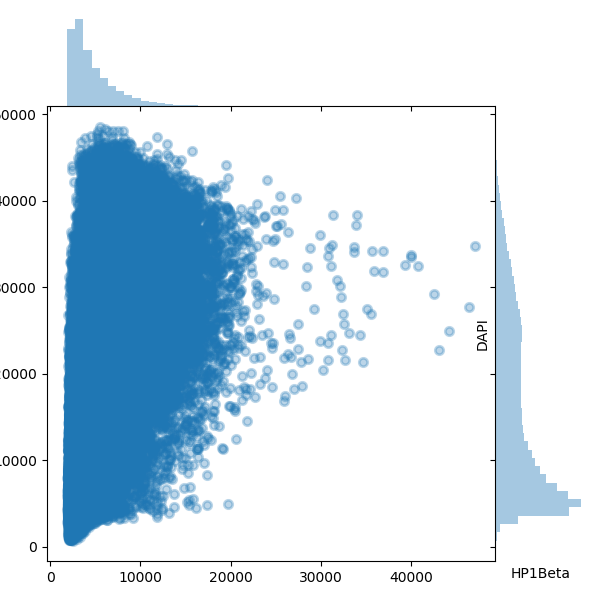

Text(468.01587301587307, 0.5, 'DAPI')

In [100]:
%matplotlib notebook
sns.jointplot(x=hp1b_test_final,y=dapiB_test_final,kind='scatter', linewidth=2,alpha=0.3,space=0)
plt.xlabel('HP1Beta')
plt.ylabel('DAPI')

### HP1

<IPython.core.display.Javascript object>


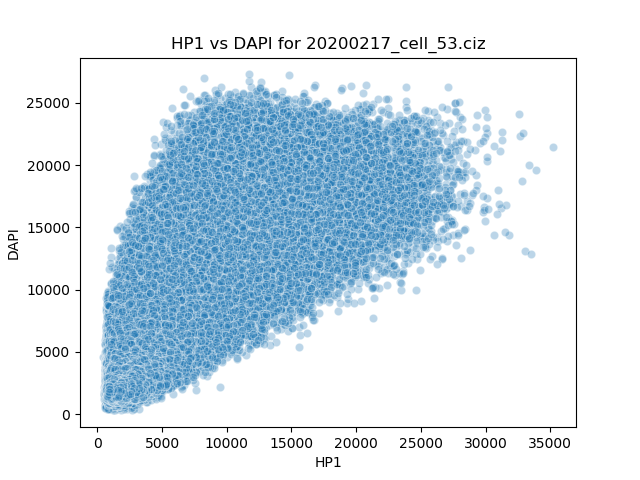

Text(0.5, 1.0, 'HP1 vs DAPI for 20200217_cell_53.ciz')

In [101]:
%matplotlib notebook
sns.scatterplot(x=hp1_test_non_zero,y=dapi_test_non_zero,alpha=0.3)
plt.ticklabel_format(axis='both',style='sci')
plt.xlabel('HP1')
plt.ylabel('DAPI')
plt.title(f'HP1 vs DAPI for {mycellGeminin.file}')

<IPython.core.display.Javascript object>


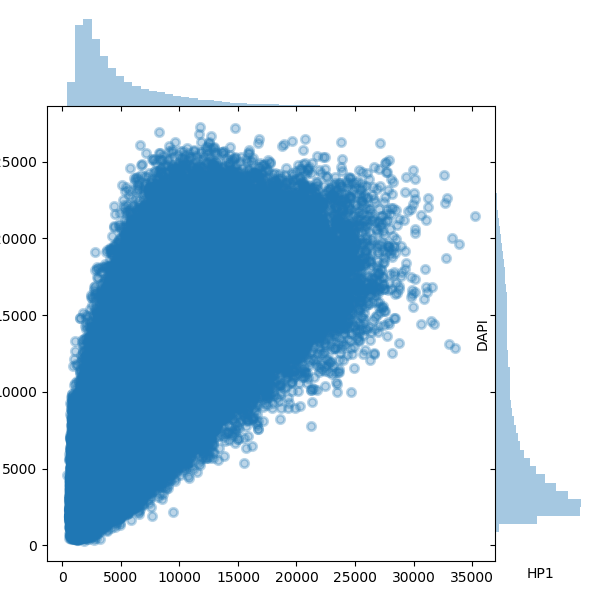

Text(468.01587301587307, 0.5, 'DAPI')

In [103]:
%matplotlib notebook
sns.jointplot(x=hp1_test_non_zero,y=dapi_test_non_zero,kind='scatter', linewidth=2,alpha=0.3,space=0)
plt.xlabel('HP1')
plt.ylabel('DAPI')

## Sample plots <a name="2Sample"></a>

In [104]:
idx = np.random.choice(np.arange(len(hp1_test_non_zero)), 1000, replace=False)
hp1_test_sample = hp1_test_non_zero[idx]
dapi_test_sample = dapi_test_non_zero[idx]

In [105]:
hp1_test_sample.shape

(1000,)

<IPython.core.display.Javascript object>


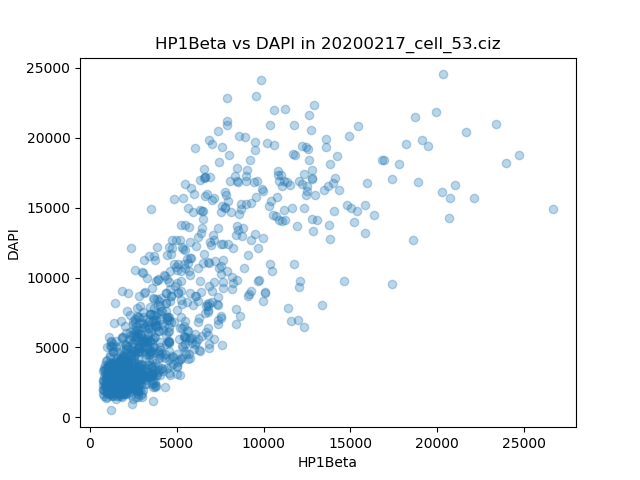

Text(0.5, 1.0, 'HP1Beta vs DAPI in 20200217_cell_53.ciz')

In [106]:
%matplotlib notebook
plt.scatter(x=hp1_test_sample, y= dapi_test_sample, alpha=0.3)
plt.xlabel('HP1Beta')
plt.ylabel('DAPI')
plt.title(f'HP1Beta vs DAPI in {mycellGeminin.file}')

In [152]:
idx = np.random.choice(np.arange(len(hp1b_test_final)), 1000, replace=False)
hp1b_test_sample = hp1b_test_final[idx]
dapiB_test_sample = dapiB_test_final[idx]

In [153]:
hp1b_test_sample.shape

(1000,)

<IPython.core.display.Javascript object>


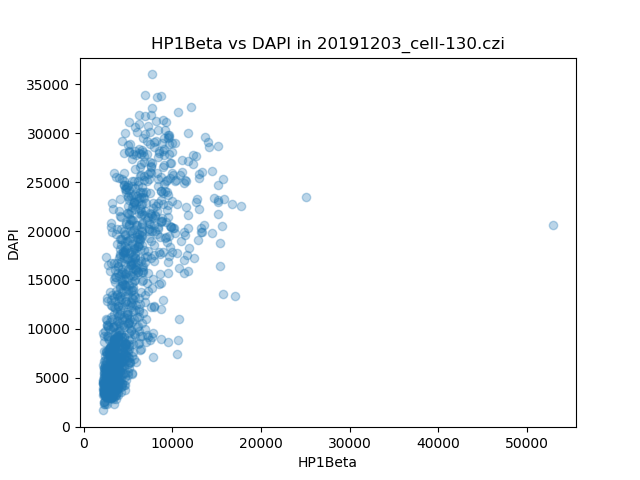

Text(0.5, 1.0, 'HP1Beta vs DAPI in 20191203_cell-130.czi')

In [154]:
%matplotlib notebook
plt.scatter(x=hp1b_test_sample, y= dapiB_test_sample, alpha=0.3)
plt.xlabel('HP1Beta')
plt.ylabel('DAPI')
plt.title(f'HP1Beta vs DAPI in {mycell.file}')

## Compare HP1 and HP1Beta  <a name="2Comparison"></a>


<IPython.core.display.Javascript object>


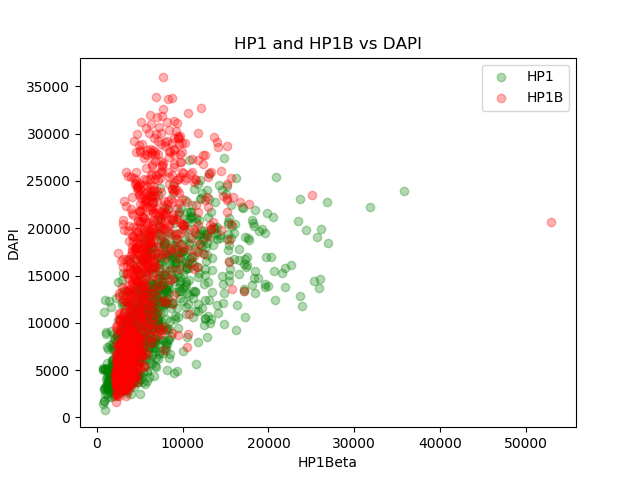

Text(0.5, 1.0, 'HP1 and HP1B vs DAPI')

In [155]:
%matplotlib notebook
plt.scatter(x=hp1_test_sample, y= dapi_test_sample, alpha=0.3, color='green', label='HP1')
plt.scatter(x=hp1b_test_sample, y= dapiB_test_sample, alpha=0.3, color='red', label='HP1B')

plt.legend()
plt.xlabel('HP1Beta')
plt.ylabel('DAPI')
plt.title(f'HP1 and HP1B vs DAPI')

# third image <a name="3rd"></a>
* [Density plots](#3Density)
* [Sample plots](#3Sample)
* [Comparison](#3Comparison)

In [156]:
i+=1
mycell=sample.iloc[i]
%matplotlib notebook
cell=imread(mycell.path)

nucPath=(mycell.path.replace('data_tiff','segmentation_nucleus_Otsu'))
nucPath=nucPath.replace('.tif','_nucleus.tif')
nuc=imread(nucPath)

print("HP1B")
print(mycell.file)
print('shape of the cell image: ', cell.shape)
print('shape of nucleus mask: ', nuc.shape)

nuc=nuc.astype(bool)
# selecting every slide of the selected channel, which is hp1beta channel.
hp1b=cell[:,1,:,:] 
## masking the image
hp1b[~nuc]=0
hp1b=hp1b.astype(np.ndarray)

# DAPI channel
dapiB=cell[:,2,:,:]
dapiB[~nuc]=0


mycellGeminin=sample_geminin.iloc[i]
%matplotlib notebook
cell=imread(mycellGeminin.path)

nucPath=(mycellGeminin.path.replace('data_tiff','segmentation_nucleus_Otsu'))
nucPath=nucPath.replace('.tif','_nucleus.tif')
nuc=imread(nucPath)

print("HP1")
print(mycellGeminin.file)
print('shape of the cell image: ', cell.shape)
print('shape of nucleus mask: ', nuc.shape)

nuc=nuc.astype(bool)
# selecting every slide of the selected channel, which is hp1beta channel.
hp1=cell[:,1,:,:] 
## masking the image
hp1[~nuc]=0
hp1=hp1.astype(np.ndarray)

# DAPI channel
dapi=cell[:,2,:,:]
dapi[~nuc]=0


HP1B
20191203_cell-03.czi
shape of the cell image:  (37, 3, 380, 380)
shape of nucleus mask:  (37, 380, 380)
HP1
20200217_cell_53.ciz
shape of the cell image:  (24, 3, 380, 380)
shape of nucleus mask:  (24, 380, 380)


In [157]:
hp1b_test=hp1b.ravel()
dapiB_test=dapiB.ravel()

In [158]:
hp1b_test.shape

(5342800,)

In [159]:
dapiB_test.shape

(5342800,)

In [160]:
hp1_test=hp1.ravel()
dapi_test=dapi.ravel()

#### remove 0 

In [161]:
hp1_test_non_zero=hp1_test[~(hp1_test==0)]
hp1_test_non_zero.shape

(328497,)

In [162]:
dapi_test_non_zero=dapi_test[~(dapi_test==0)]
dapi_test_non_zero.shape

(328497,)

In [164]:
hp1b_test_non_zero=hp1b_test[~(hp1b_test==0)]
hp1b_test_non_zero.shape

(223869,)

In [165]:
dapiB_test_non_zero=dapiB_test[~(dapiB_test==0)]
dapiB_test_non_zero.shape

(223869,)

## Density plot <a name="3Density"></a>

### HP1Beta

In [166]:
hp1b_test_final=hp1b_test_non_zero[hp1b_test_non_zero!=hp1b_test_non_zero.max()]

In [167]:
dapiB_test_final=dapiB_test_non_zero[hp1b_test_non_zero!=hp1b_test_non_zero.max()]

In [168]:
print(hp1b_test_final.shape)
print(dapiB_test_final.shape)

(223868,)
(223868,)


<IPython.core.display.Javascript object>


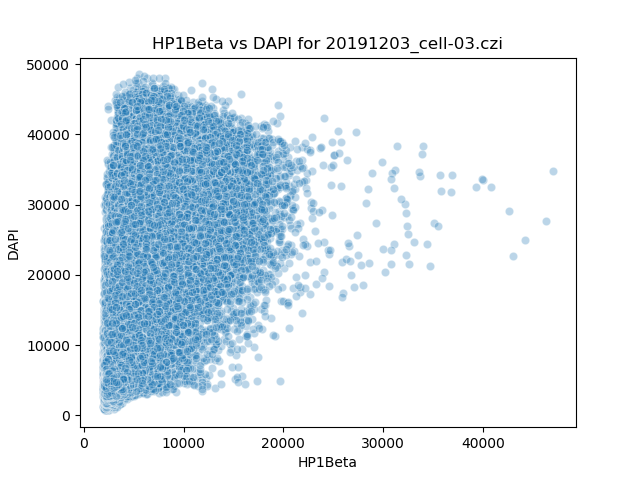

Text(0.5, 1.0, 'HP1Beta vs DAPI for 20191203_cell-03.czi')

In [169]:
%matplotlib notebook
sns.scatterplot(x=hp1b_test_final,y=dapiB_test_final,alpha=0.3)
plt.ticklabel_format(axis='both',style='sci')
plt.xlabel('HP1Beta')
plt.ylabel('DAPI')
plt.title(f'HP1Beta vs DAPI for {mycell.file}')

<IPython.core.display.Javascript object>


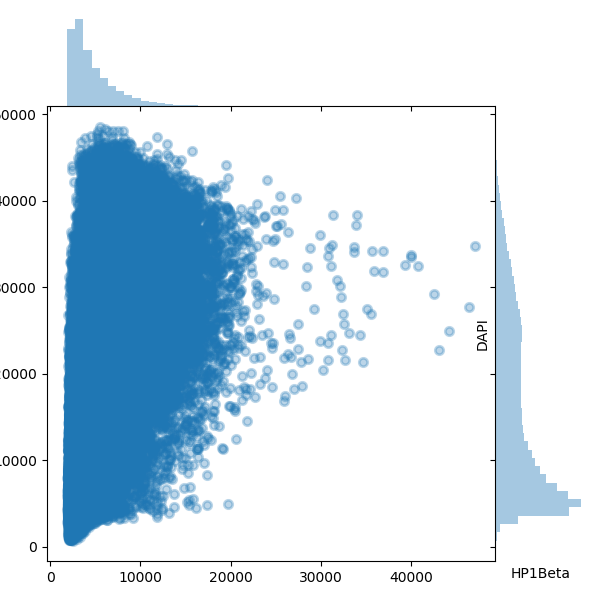

Text(468.01587301587307, 0.5, 'DAPI')

In [170]:
%matplotlib notebook
sns.jointplot(x=hp1b_test_final,y=dapiB_test_final,kind='scatter', linewidth=2,alpha=0.3,space=0)
plt.xlabel('HP1Beta')
plt.ylabel('DAPI')

### HP1

<IPython.core.display.Javascript object>


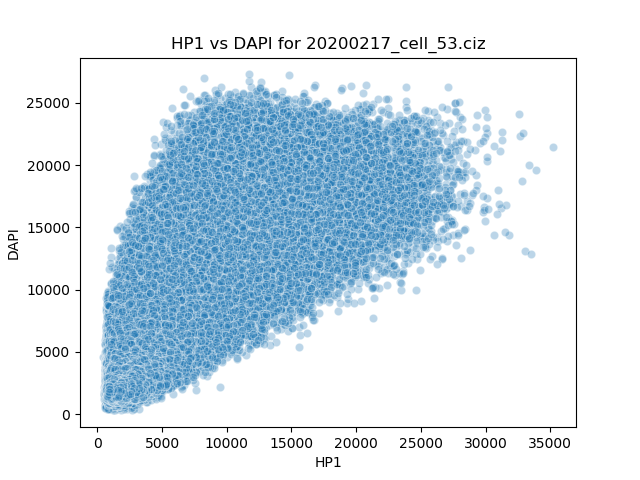

Text(0.5, 1.0, 'HP1 vs DAPI for 20200217_cell_53.ciz')

In [172]:
%matplotlib notebook
sns.scatterplot(x=hp1_test_non_zero,y=dapi_test_non_zero,alpha=0.3)
plt.ticklabel_format(axis='both',style='sci')
plt.xlabel('HP1')
plt.ylabel('DAPI')
plt.title(f'HP1 vs DAPI for {mycellGeminin.file}')

<IPython.core.display.Javascript object>


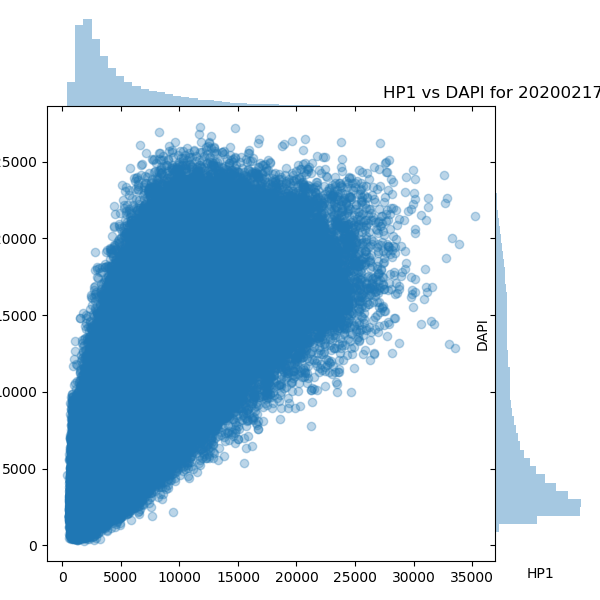

Text(0.5, 1, 'HP1 vs DAPI for 20200217_cell_53.ciz')

In [173]:
%matplotlib notebook
sns.jointplot(x=hp1_test_non_zero,y=dapi_test_non_zero,alpha=0.3, space=0)
plt.ticklabel_format(axis='both',style='sci')
plt.xlabel('HP1')
plt.ylabel('DAPI')
plt.title(f'HP1 vs DAPI for {mycellGeminin.file}')

## Sample plots <a name="2Sample"></a>

In [174]:
idx = np.random.choice(np.arange(len(hp1_test_non_zero)), 1000, replace=False)
hp1_test_sample = hp1_test_non_zero[idx]
dapi_test_sample = dapi_test_non_zero[idx]

In [175]:
hp1_test_sample.shape

(1000,)

<IPython.core.display.Javascript object>


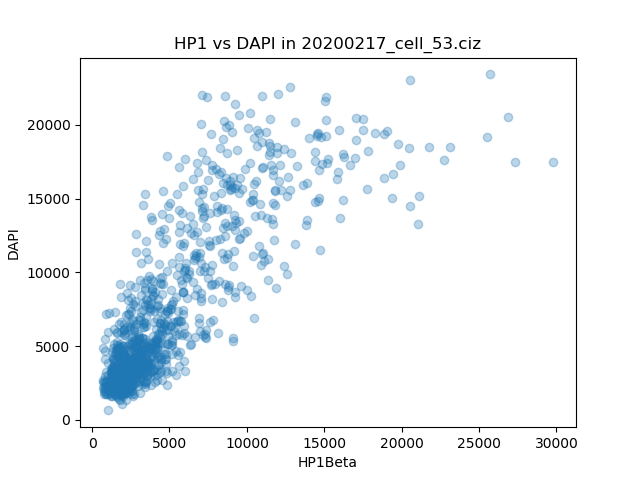

Text(0.5, 1.0, 'HP1 vs DAPI in 20200217_cell_53.ciz')

In [176]:
%matplotlib notebook
plt.scatter(x=hp1_test_sample, y= dapi_test_sample, alpha=0.3)
plt.xlabel('HP1Beta')
plt.ylabel('DAPI')
plt.title(f'HP1 vs DAPI in {mycellGeminin.file}')

In [177]:
idx = np.random.choice(np.arange(len(hp1b_test_final)), 1000, replace=False)
hp1b_test_sample = hp1b_test_final[idx]
dapiB_test_sample = dapiB_test_final[idx]

In [178]:
hp1b_test_sample.shape

(1000,)

<IPython.core.display.Javascript object>


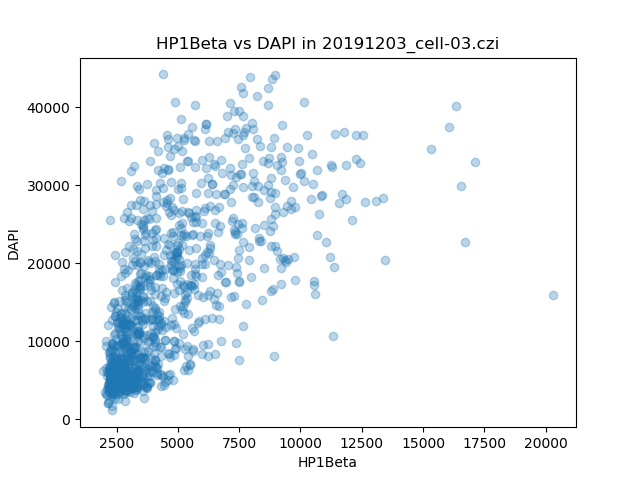

Text(0.5, 1.0, 'HP1Beta vs DAPI in 20191203_cell-03.czi')

In [179]:
%matplotlib notebook
plt.scatter(x=hp1b_test_sample, y= dapiB_test_sample, alpha=0.3)
plt.xlabel('HP1Beta')
plt.ylabel('DAPI')
plt.title(f'HP1Beta vs DAPI in {mycell.file}')

## Compare HP1 and HP1Beta  <a name="2Comparison"></a>


<IPython.core.display.Javascript object>


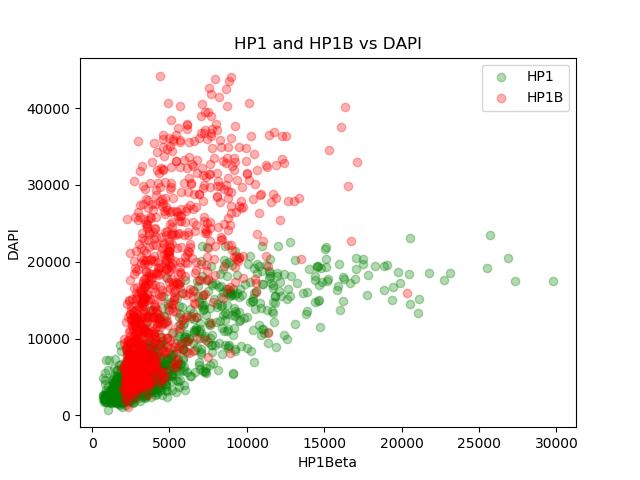

Text(0.5, 1.0, 'HP1 and HP1B vs DAPI')

In [180]:
%matplotlib notebook
plt.scatter(x=hp1_test_sample, y= dapi_test_sample, alpha=0.3, color='green', label='HP1')
plt.scatter(x=hp1b_test_sample, y= dapiB_test_sample, alpha=0.3, color='red', label='HP1B')

plt.legend()
plt.xlabel('HP1Beta')
plt.ylabel('DAPI')
plt.title(f'HP1 and HP1B vs DAPI')

# Compare mean and max values <a name="meanMax"></a>

For *Beta* value
- ***FALSE*** = ***HP1***
- ***TRUE*** = ***HP1Beta***

In [181]:
maxValues=pd.DataFrame(columns=['File','HP1','DAPI','Beta'])

In [182]:
for k, cell in sample.iterrows():
    
    cellimg=imread(cell.path)

    nucPath=(cell.path.replace('data_tiff','segmentation_nucleus_Otsu'))
    nucPath=nucPath.replace('.tif','_nucleus.tif')
    nuc=imread(nucPath)
    
    nuc=nuc.astype(bool)
    # selecting every slide of the selected channel, which is hp1beta channel.
    hp1b=cellimg[:,1,:,:] 
    ## masking the image
    hp1b[~nuc]=0
    hp1b=hp1b.astype(np.ndarray)
    hp1b_test=hp1b.ravel()
    # DAPI channel
    dapiB=cellimg[:,2,:,:]
    dapiB[~nuc]=0
    dapiB=dapiB.astype(np.ndarray)
    dapiB_test=dapiB.ravel()
    
    newrow={'File':cell.file, 'HP1': hp1b_test.max(), 'DAPI': dapiB_test.max(), 'Beta': True}
    maxValues=maxValues.append(newrow,ignore_index=True)

In [183]:
maxValues

File    HP1   DAPI  Beta
0  20191203_cell-130.czi  65535  41919  True
1   20191203_cell-03.czi  51084  48541  True
2  20191203_cell-137.czi  65535  41988  True
3   20191203_cell-78.czi  42330  38402  True
4   20191203_cell-64.czi  65535  39164  True
5   20191203_cell-87.czi  65535  41338  True
6  20191203_cell-103.czi  29370  41736  True
7   20191203_cell-80.czi  41713  35911  True
8  20191203_cell-123.czi  39001  36781  True
9   20191203_cell-05.czi  63504  45029  True

In [184]:
for k, cell in sample_geminin.iterrows():
    
    cellimg=imread(cell.path)

    nucPath=(cell.path.replace('data_tiff','segmentation_nucleus_Otsu'))
    nucPath=nucPath.replace('.tif','_nucleus.tif')
    nuc=imread(nucPath)
    
    nuc=nuc.astype(bool)
    # selecting every slide of the selected channel, which is hp1beta channel.
    hp1=cellimg[:,1,:,:] 
    ## masking the image
    hp1[~nuc]=0
    hp1=hp1.astype(np.ndarray)
    hp1_test=hp1.ravel()
    # DAPI channel
    dapi=cellimg[:,2,:,:]
    dapi[~nuc]=0
    dapi=dapi.astype(np.ndarray)
    dapi_test=dapi.ravel()
    
    newrow={'File':cell.file, 'HP1': hp1_test.max(), 'DAPI': dapi_test.max(), 'Beta': False}
    maxValues=maxValues.append(newrow,ignore_index=True)

In [185]:
maxValues

File    HP1   DAPI   Beta
0   20191203_cell-130.czi  65535  41919   True
1    20191203_cell-03.czi  51084  48541   True
2   20191203_cell-137.czi  65535  41988   True
3    20191203_cell-78.czi  42330  38402   True
4    20191203_cell-64.czi  65535  39164   True
5    20191203_cell-87.czi  65535  41338   True
6   20191203_cell-103.czi  29370  41736   True
7    20191203_cell-80.czi  41713  35911   True
8   20191203_cell-123.czi  39001  36781   True
9    20191203_cell-05.czi  63504  45029   True
10   20200217_cell_56.ciz  47432  31365  False
11   20200217_cell_53.ciz  35243  27284  False
12   20200217_cell_41.ciz  45505  25841  False
13   20200217_cell_33.ciz  60363  28017  False
14   20200217_cell_00.ciz  65253  22982  False
15   20200217_cell_39.ciz  39329  24180  False
16   20200217_cell_60.ciz  41541  30859  False
17   20200217_cell_59.ciz  37076  29629  False
18   20200217_cell_09.ciz  63535  35604  False
19   20200217_cell_12.ciz  42849  23587  False

<IPython.core.display.Javascript object>


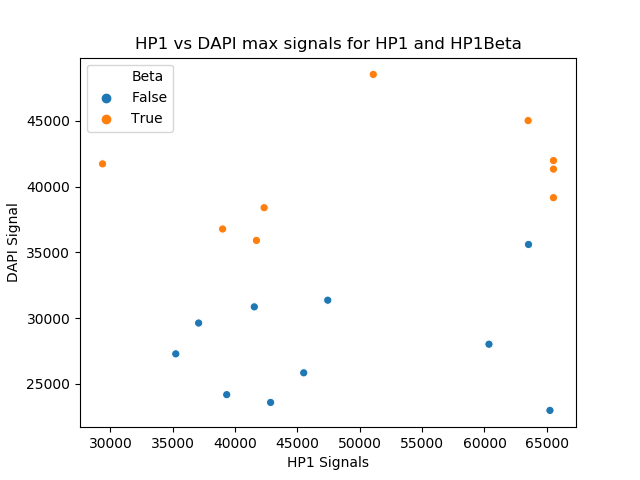

Text(0.5, 1.0, 'HP1 vs DAPI max signals for HP1 and HP1Beta')

In [195]:
%matplotlib notebook
sns.scatterplot(x='HP1',y='DAPI',data=maxValues,hue='Beta')
plt.xlabel('HP1 Signals')
plt.ylabel('DAPI Signal')
plt.title('HP1 vs DAPI max signals for HP1 and HP1Beta')

<IPython.core.display.Javascript object>


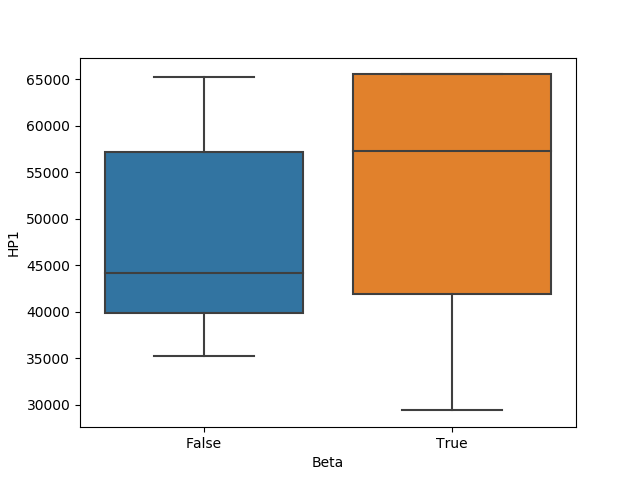

In [194]:
%matplotlib notebook
sns.boxplot(x='Beta',y='HP1',data=maxValues)

In [188]:
meanValues=pd.DataFrame(columns=['File','HP1','DAPI','Beta'])

In [189]:
for k, cell in sample.iterrows():
    
    cellimg=imread(cell.path)

    nucPath=(cell.path.replace('data_tiff','segmentation_nucleus_Otsu'))
    nucPath=nucPath.replace('.tif','_nucleus.tif')
    nuc=imread(nucPath)
    
    nuc=nuc.astype(bool)
    # selecting every slide of the selected channel, which is hp1beta channel.
    hp1b=cellimg[:,1,:,:] 
    ## masking the image
    hp1b[~nuc]=0
    hp1b=hp1b.astype(np.ndarray)
    hp1b_test=hp1b.ravel()
    # DAPI channel
    dapiB=cellimg[:,2,:,:]
    dapiB[~nuc]=0
    dapiB=dapiB.astype(np.ndarray)
    dapiB_test=dapiB.ravel()
    
    newrow={'File':cell.file, 'HP1': hp1b_test.mean(), 'DAPI': dapiB_test.mean(), 'Beta': True}
    meanValues=meanValues.append(newrow,ignore_index=True)
    
for k, cell in sample_geminin.iterrows():
    
    cellimg=imread(cell.path)

    nucPath=(cell.path.replace('data_tiff','segmentation_nucleus_Otsu'))
    nucPath=nucPath.replace('.tif','_nucleus.tif')
    nuc=imread(nucPath)
    
    nuc=nuc.astype(bool)
    # selecting every slide of the selected channel, which is hp1beta channel.
    hp1=cellimg[:,1,:,:] 
    ## masking the image
    hp1[~nuc]=0
    hp1=hp1.astype(np.ndarray)
    hp1_test=hp1.ravel()
    # DAPI channel
    dapi=cellimg[:,2,:,:]
    dapi[~nuc]=0
    dapi=dapi.astype(np.ndarray)
    dapi_test=dapi.ravel()
    
    newrow={'File':cell.file, 'HP1': hp1_test.mean(), 'DAPI': dapi_test.mean(), 'Beta': False}
    meanValues=meanValues.append(newrow,ignore_index=True)

In [190]:
meanValues

File         HP1        DAPI   Beta
0   20191203_cell-130.czi  307.060886  778.511280   True
1    20191203_cell-03.czi  198.798824  675.932091   True
2   20191203_cell-137.czi  299.403692  774.021131   True
3    20191203_cell-78.czi  247.799321  639.948891   True
4    20191203_cell-64.czi  313.431043  719.287832   True
5    20191203_cell-87.czi  253.892113  760.166054   True
6   20191203_cell-103.czi  240.001007  745.173137   True
7    20191203_cell-80.czi  237.842481  530.655839   True
8   20191203_cell-123.czi  297.809537  779.742789   True
9    20191203_cell-05.czi  329.035145  727.197137   True
10   20200217_cell_56.ciz  456.811871  727.417204  False
11   20200217_cell_53.ciz  460.478258  680.197284  False
12   20200217_cell_41.ciz  473.024595  626.572252  False
13   20200217_cell_33.ciz  537.862654  597.129002  False
14   20200217_cell_00.ciz  981.863801  726.527012  False
15   20200217_cell_39.ciz  522.895891  576.093596  False
16   20200217_cell_60.ciz  409.194787  530.170253  False
17   20200217_cell_59.ciz  429.836755  664.113975  False
18   20200217_cell_09.ciz  612.494207  637.955924  False
19   20200217_cell_12.ciz  747.559674  758.306264  False

<IPython.core.display.Javascript object>


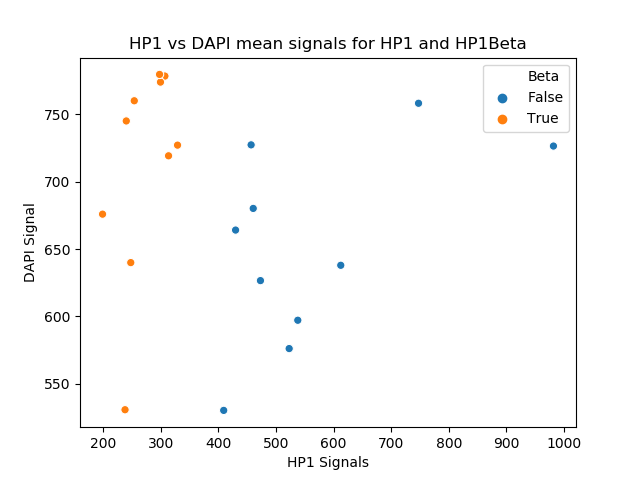

Text(0.5, 1.0, 'HP1 vs DAPI mean signals for HP1 and HP1Beta')

In [193]:
%matplotlib notebook
sns.scatterplot(x='HP1',y='DAPI',data=meanValues,hue='Beta')
plt.xlabel('HP1 Signals')
plt.ylabel('DAPI Signal')
plt.title('HP1 vs DAPI mean signals for HP1 and HP1Beta')

<IPython.core.display.Javascript object>


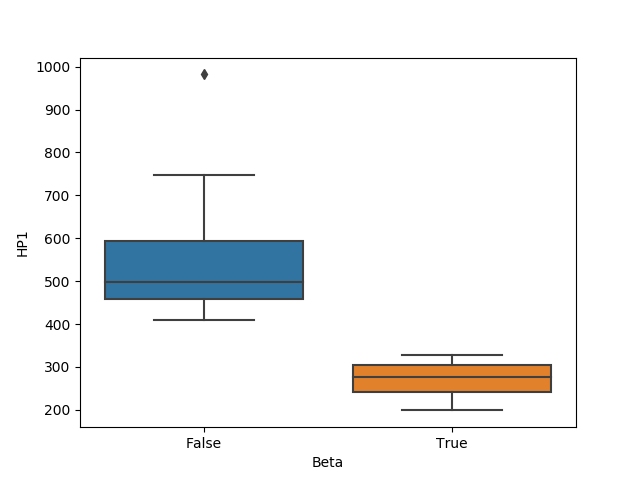

In [192]:
%matplotlib notebook
sns.boxplot(x='Beta',y='HP1',data=meanValues)